In [1]:
import ast
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
from tqdm import tqdm
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')

In [3]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [4]:
print("train.csv shape: ", train.shape)
print("train_labels.csv shape: ", train_labels.shape)
print("test.csv shape: ", test.shape)

train.csv shape:  (7734558, 11)
train_labels.csv shape:  (17690, 7)
test.csv shape:  (1156414, 11)


In [5]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

# title of games/videos when the type is assessment
it always includes (Assessment) in the title

In [6]:
train[train.type=="Assessment"]["title"].value_counts()

Mushroom Sorter (Assessment)    192906
Bird Measurer (Assessment)      188466
Chest Sorter (Assessment)       186421
Cauldron Filler (Assessment)    177669
Cart Balancer (Assessment)      158143
Name: title, dtype: int64

# finding match between train and train_labels by one id

In [7]:
summarized_df = train_labels[train_labels.installation_id == "0006a69f"]
#summarized_df.to_csv("summarized_result.csv", index=False)
summarized_df

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [8]:
#train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
#                                               (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

In [9]:
train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4100))].shape[0]

13

When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (1 correct, 11 incorrect)

In [10]:
#train[(train.installation_id == "0006a69f") & (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110)]

In [11]:
train[(train.installation_id == "0006a69f") & (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110)].shape[0]

12

in terms of Mushroom Sorter (Assessment), there's no Mushromm Sorter/4110 row.

In [12]:
#train[(train.installation_id == "0006a69f") &  (train.type == "Assessment") & (train.title == 'Mushroom Sorter (Assessment)') & (train.event_code == 4100)]

In [13]:
assessment_df = train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]
assessment_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday


In [14]:
all_data = train[train.installation_id == "0006a69f"]
all_data

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,4,Tuesday
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,4,Tuesday
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,832735e1,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3797,ab3136ba,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3798,832735e1,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3799,ab3136ba,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday


In [15]:
# list of index after assessment, which don't have to do with assessments
#remove_id = []
#for i in train_labels.installation_id.unique():
#    print("id: ", i)
#    game_sesion_in_id = train_labels[train_labels.installation_id == str(i)]["game_session"]
#    tmp_indexes = [train[train.game_session == str(i)].index[-1] for i in game_sesion_in_id]
#    remove_first = max(tmp_indexes)+1
#    remove_last = train[train.installation_id == str(i)].index[-1]
#    print(remove_first)
#    print(remove_last)
#    for j in range(remove_first, remove_last+1):
#        remove_id.append(j)

In [16]:
# game_session and title is connected with one by one.
# all_data.groupby("game_session")["title"].value_counts()

In [17]:
# game_session and type is connected with one by one.
# all_data.groupby("game_session")["type"].value_counts()

In [18]:
# game_session and world is connected with one by one
# all_data.groupby("game_session")["world"].value_counts()

In [19]:
all_data[all_data["event_data"].str.contains("correct")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
113,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:25.191000+00:00,"{""size"":1,""item_type"":""Tub"",""position"":1,""anim...",0006a69f,9,4020,11886,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
118,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:26.585000+00:00,"{""size"":4,""item_type"":""Tub"",""position"":2,""anim...",0006a69f,14,4020,13286,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
127,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:36.930000+00:00,"{""size"":4,""item_type"":""Water"",""position"":2,""an...",0006a69f,23,4020,23628,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
130,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:38.438000+00:00,"{""size"":1,""item_type"":""Water"",""position"":1,""an...",0006a69f,26,4020,25137,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
135,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:39.729000+00:00,"{""size"":4,""item_type"":""Water"",""position"":2,""an...",0006a69f,31,4020,26433,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
145,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:50.131000+00:00,"{""size"":1,""item_type"":""Soap"",""position"":1,""ani...",0006a69f,41,4020,36837,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
151,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:51.483000+00:00,"{""size"":4,""item_type"":""Soap"",""position"":2,""ani...",0006a69f,47,4020,38187,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
164,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:02:22.188000+00:00,"{""size"":3,""item_type"":""Tub"",""position"":1,""anim...",0006a69f,60,4020,68889,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
167,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:02:24.286000+00:00,"{""size"":4,""item_type"":""Tub"",""position"":3,""anim...",0006a69f,63,4020,70989,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
172,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:02:25.862000+00:00,"{""size"":3,""item_type"":""Tub"",""position"":1,""anim...",0006a69f,68,4020,72572,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday


In [20]:
print("no of irrelevant instances")
print("bird measurer(assessment) with 4100: ", all_data[(all_data.event_code == 4100) & (all_data.title == "Bird Measurer (Assessment)")].shape[0])
print("mushroom sorter(assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "Mushroom Sorter (Assessment)")].shape[0])
print("Chest Sorter (assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "Chest Sorter (Assessment)")].shape[0])
print("Cart Balancer (assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "(Assessment)")].shape[0])

no of irrelevant instances
bird measurer(assessment) with 4100:  1
mushroom sorter(assessment) with 4110:  0
Chest Sorter (assessment) with 4110:  0
Cart Balancer (assessment) with 4110:  0


In [21]:
# how about other installation_ids?: totally 2352 bird measurer/4100 rows
print("no of irrelevant instances")
print("bird measurer(assessment) with 4100: ", train[(train.event_code == 4100) & (train.title == "Bird Measurer (Assessment)")].shape[0])
print("mushroom sorter(assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "Mushroom Sorter (Assessment)")].shape[0])
print("Chest Sorter (assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "Chest Sorter (Assessment)")].shape[0])
print("Cart Balancer (assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "(Assessment)")].shape[0])

no of irrelevant instances
bird measurer(assessment) with 4100:  2352
mushroom sorter(assessment) with 4110:  0
Chest Sorter (assessment) with 4110:  0
Cart Balancer (assessment) with 4110:  0


# distribution of test 

In [22]:
test["installation_id"].unique()

array(['00abaee7', '01242218', '017c5718', '01a44906', '01bc6cb6',
       '02256298', '0267757a', '027e7ce5', '02a29f99', '0300c576',
       '03885368', '03ac279b', '03e33699', '048e7427', '04a7bc3f',
       '04d31500', '0500e23b', '0512bf0e', '0525589b', '05488e26',
       '05771bba', '05b82cf5', '05e17e19', '0617500d', '068ae11f',
       '0754f13b', '07749e99', '08611cc8', '08671ec7', '0889b0ae',
       '090fe325', '0937340d', '09aaaf83', '09aefe80', '0a126293',
       '0a2a77b2', '0a4c0f78', '0af94ba5', '0b24b6ac', '0b607c82',
       '0d5735f2', '0d735146', '0d7752d3', '0dd670e9', '0de6863d',
       '0e514571', '0e718764', '0ea27b66', '0f584054', '0f7116a6',
       '101999d8', '101d16f5', '108044a0', '109ad724', '10acf963',
       '1121f331', '1181ce7c', '11fa34d0', '125a3d09', '12771ee9',
       '1294d68e', '12bcbbce', '13629687', '138a2ecc', '13a0754c',
       '13bcaf23', '13cf3fc0', '13d608cb', '140087ce', '140ea7a3',
       '1423dc8f', '14cdc97f', '153f087c', '1594c19e', '15d869

In [23]:
#for i in range(test[(test["installation_id"] == "00abaee7") & (test.type == "Game")].shape[0]):#
#    print(test[(test["installation_id"] == "00abaee7") & (test.type == "Game")].iloc[i]["event_#data"])

In [24]:
test[test["installation_id"] == "50797f53"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
347096,4901243f,30abb60176577135,2019-09-27 22:12:11.720000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",50797f53,1,2000,0,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347097,beb0a7b9,30abb60176577135,2019-09-27 22:12:11.746000+00:00,"{""description"":""Let's set off these fireworks....",50797f53,2,3010,0,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347098,b88f38da,30abb60176577135,2019-09-27 22:12:15.690000+00:00,"{""description"":""Let's set off these fireworks....",50797f53,3,3110,4090,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347099,884228c8,30abb60176577135,2019-09-27 22:12:18.240000+00:00,"{""coordinates"":{""x"":631,""y"":647,""stage_width"":...",50797f53,4,4070,6623,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347100,884228c8,30abb60176577135,2019-09-27 22:12:18.971000+00:00,"{""coordinates"":{""x"":593,""y"":666,""stage_width"":...",50797f53,5,4070,7356,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347101,02a42007,30abb60176577135,2019-09-27 22:12:19.358000+00:00,"{""rocket"":6,""coordinates"":{""x"":613,""y"":684,""st...",50797f53,6,4030,7739,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347102,e694a35b,30abb60176577135,2019-09-27 22:12:19.753000+00:00,"{""rocket"":6,""height"":681,""duration"":350,""coord...",50797f53,7,4020,8089,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347103,884228c8,30abb60176577135,2019-09-27 22:12:19.907000+00:00,"{""coordinates"":{""x"":799,""y"":643,""stage_width"":...",50797f53,8,4070,8306,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347104,884228c8,30abb60176577135,2019-09-27 22:12:20.163000+00:00,"{""coordinates"":{""x"":763,""y"":647,""stage_width"":...",50797f53,9,4070,8556,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347105,884228c8,30abb60176577135,2019-09-27 22:12:20.346000+00:00,"{""coordinates"":{""x"":735,""y"":627,""stage_width"":...",50797f53,10,4070,8739,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday


In [25]:
tmp = test[(test["installation_id"] == "08611cc8")]
tmp[(tmp.world == tmp.iloc[-1]["world"])]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
26098,27253bdc,589fd3b020402444,2019-08-23 21:05:15.461000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-23,21,Friday
26099,27253bdc,40ee12716c9a10e4,2019-08-23 21:06:11.266000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-08-23,21,Friday
26100,27253bdc,d00ab8dcd99ef31f,2019-08-23 21:08:36.364000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-08-23,21,Friday
26101,90d848e0,9d7c0e9474002d55,2019-08-23 21:09:31.586000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",08611cc8,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-08-23,21,Friday


In [26]:
tmp[(tmp.world == tmp.iloc[-1]["world"])].iloc[32]["event_data"]

IndexError: single positional indexer is out-of-bounds

In [27]:
print(train[(train.type=="Clip") & (train.world == "MAGMAPEAK")]["title"].unique())
print(train[(train.type=="Clip") & (train.world == "TREETOPCITY")]["title"].unique())
print(train[(train.type=="Clip") & (train.world == "CRYSTALCAVES")]["title"].unique())

['Magma Peak - Level 1' 'Slop Problem' 'Magma Peak - Level 2']
['Tree Top City - Level 1' 'Ordering Spheres' 'Costume Box' '12 Monkeys'
 'Tree Top City - Level 2' "Pirate's Tale" 'Treasure Map'
 'Tree Top City - Level 3' 'Rulers']
['Crystal Caves - Level 1' 'Balancing Act' 'Crystal Caves - Level 2'
 'Crystal Caves - Level 3' 'Lifting Heavy Things' 'Honey Cake'
 'Heavy, Heavier, Heaviest']


In [28]:
print(test[(test.type=="Clip") & (test.world == "MAGMAPEAK") ]["title"].unique())
print(test[(test.type=="Clip") & (test.world == "TREETOPCITY") ]["title"].unique())
print(test[(test.type=="Clip") & (test.world == "CRYSTALCAVES") ]["title"].unique())

['Magma Peak - Level 1' 'Magma Peak - Level 2' 'Slop Problem']
['Tree Top City - Level 1' 'Costume Box' '12 Monkeys' 'Ordering Spheres'
 'Tree Top City - Level 2' "Pirate's Tale" 'Treasure Map'
 'Tree Top City - Level 3' 'Rulers']
['Crystal Caves - Level 1' 'Balancing Act' 'Crystal Caves - Level 2'
 'Lifting Heavy Things' 'Crystal Caves - Level 3' 'Honey Cake'
 'Heavy, Heavier, Heaviest']


# How to remove data after assessment in training 

In [29]:
%%time
assess_title = ['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)', 'Cart Balancer (Assessment)',
       'Chest Sorter (Assessment)']
tmp = pd.DataFrame.from_dict(all_data.groupby("game_session").groups.values())
tmp["title"] = all_data.groupby("game_session")["title"].unique().reset_index(drop = True).apply(lambda x: x[0])
tmp["min"] = np.min(tmp, axis=1)
tmp["max"] = np.max(tmp, axis=1)
tmp = tmp.sort_values("min", ascending=True).reset_index(drop=True)
tmp = tmp[["title", "min", "max"]]
last_row = int(tmp.iloc[-1]["max"])
first_row = int(tmp[tmp.title.isin(assess_title)].iloc[-1]["max"] + 1)
print(first_row, last_row)

2618 3800
CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 95.5 ms


In [30]:
%%time
first_rows = []
last_rows = []
for i in tqdm(train.installation_id.unique()):
    all_data = train[train.installation_id == i]
    tmp = pd.DataFrame.from_dict(all_data.groupby("game_session").groups.values())
    tmp["title"] = all_data.groupby("game_session")["title"].unique().reset_index(drop = True).apply(lambda x: x[0])
    tmp["min"] = np.min(tmp, axis=1)
    tmp["max"] = np.max(tmp, axis=1)
    tmp = tmp.sort_values("min", ascending=True).reset_index(drop=True)
    last_row = int(tmp.iloc[-1]["max"])
    first_row = int(tmp[tmp.title.isin(assess_title)].iloc[-1]["max"] + 1)
    if first_row <= last_row:
        first_rows.append(first_row)
        last_rows.append(last_row)

100%|██████████| 3614/3614 [1:15:22<00:00,  1.25s/it]

CPU times: user 1h 15min 33s, sys: 18 s, total: 1h 15min 51s
Wall time: 1h 15min 22s


In [31]:
print(", ".join('%02d'%x for x in last_rows))

3800, 6024, 6854, 7882, 8839, 14325, 19619, 20812, 23388, 23469, 25028, 25365, 25649, 33809, 38794, 45570, 46505, 49762, 56060, 58271, 58797, 60066, 65782, 68985, 71766, 72906, 75546, 78084, 80280, 80354, 82077, 82492, 83998, 84927, 86386, 88059, 90230, 96005, 99834, 100096, 100900, 109283, 111976, 113401, 115462, 118153, 123424, 124967, 125617, 126134, 127625, 129370, 136303, 141149, 143043, 144049, 146176, 147055, 159605, 164536, 171231, 172328, 173333, 173775, 185194, 187493, 191877, 200240, 202286, 203748, 204660, 209268, 212867, 213640, 215516, 217363, 219591, 224084, 249072, 250112, 254110, 258082, 258276, 260321, 261827, 263378, 264781, 276277, 279670, 282473, 285163, 286516, 287536, 288771, 290644, 294008, 295120, 295955, 298017, 306659, 319518, 320071, 320624, 324617, 325749, 328210, 329669, 335827, 336663, 340920, 341919, 348608, 350524, 351723, 353243, 355923, 356612, 357312, 358923, 359988, 365897, 366532, 367002, 374575, 376698, 376997, 377448, 379429, 380565, 380808, 3833

In [32]:
%%time
additional_remove_index = []
for i in range(len(first_rows)):
    for j in range(first_rows[i], last_rows[i]+1):
        additional_remove_index.append(j)

CPU times: user 228 ms, sys: 24 ms, total: 252 ms
Wall time: 254 ms


# EDA

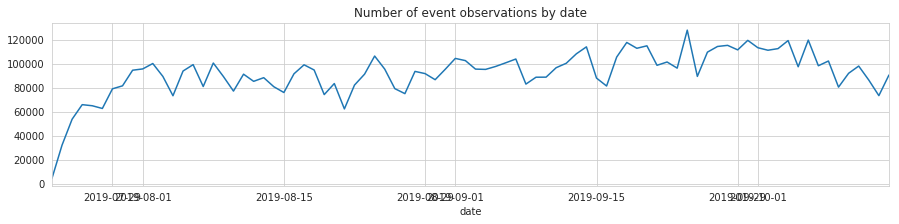

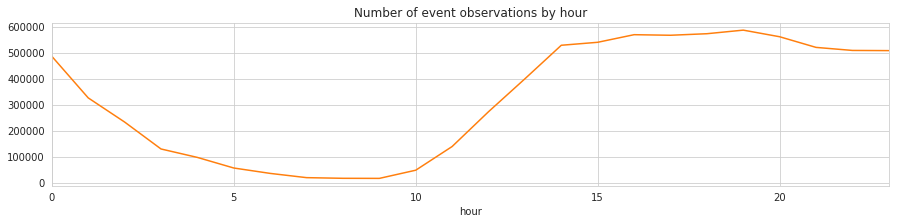

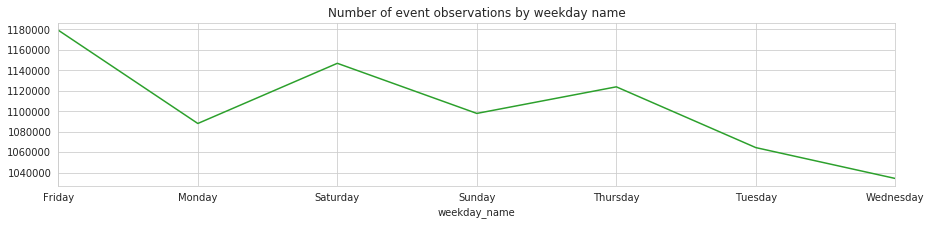

In [33]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

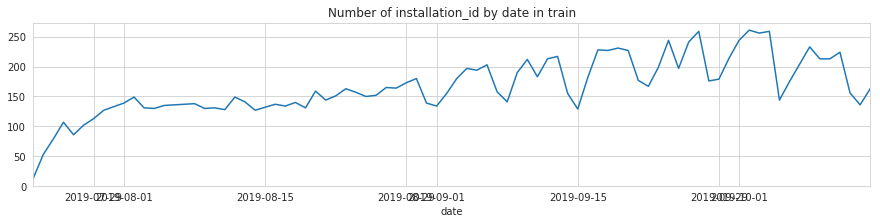

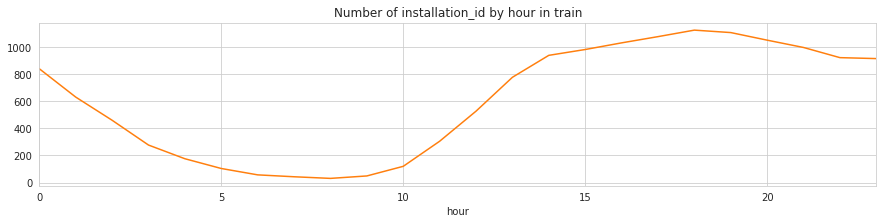

In [34]:
# can be seen as cyclic trend in the middle part of analysis period
train.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date in train", color=my_pal[0])
plt.show()
# can be seen as cyclic trend in the middle part of analysis period
train.groupby('hour')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by hour in train", color=my_pal[1])
plt.show()

In [35]:
all_df = pd.concat([train[["date", "hour", "installation_id"]], test[["date", "hour", "installation_id"]]])

In [36]:
all_df.shape

(8890972, 3)

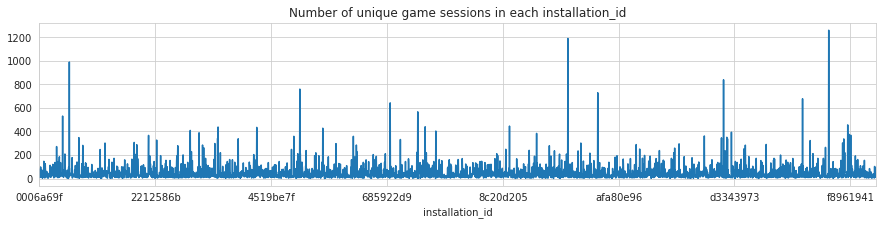

In [37]:
# several outliers
train.groupby("installation_id")["game_session"].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of unique game sessions in each installation_id", color=my_pal[0])
plt.show()

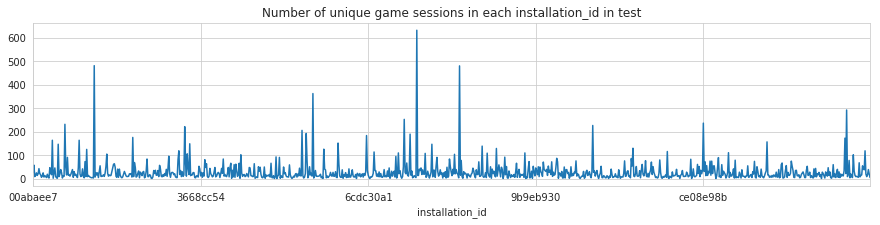

In [38]:
test.groupby("installation_id")["game_session"].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of unique game sessions in each installation_id in test", color=my_pal[0])
plt.show()

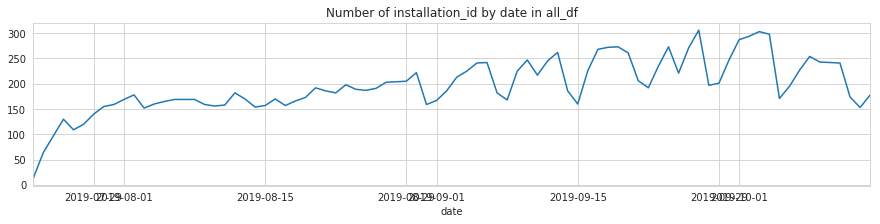

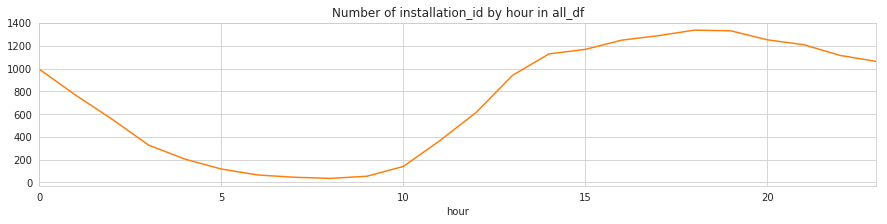

In [39]:
# can be seen as cyclic trend in the middle part of analysis period
all_df.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date in all_df", color=my_pal[0])
plt.show()
# can be seen as cyclic trend in the middle part of analysis period
all_df.groupby('hour')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by hour in all_df", color=my_pal[1])
plt.show()

# ideas of FE

In [40]:
# check if the play is follwed by recommended learning order
mushroom_sorter_recommend_order = {"Welcome to Lost Lagoon!": "Clip" ,"Tree Top City - Level 1": "Clip",
"Ordering Spheres": "Clip",  "All Star Sorting": "Game", "Costume Box": "Clip",
"Fireworks (Activity)": "Activity", "12 Monkeys": "Clip", "Tree Top City - Level 2": "Clip",
"Flower Waterer (Activity)": "Activity", "Pirate's Tale": "Clip"}

bird_measurer_recommend_order = {"Air Show": "Game", "Treasure Map": "Clip", "Tree Top City - Level 3": "Clip",
"Crystals Rule": "Game", "Rulers": "Clip", "Bug Measurer (Activity)": "Activity"}

cauldron_filter_recommend_order = {"Magma Peak - Level 1": "Clip", "Sandcastle Builder (Activity)": "Activity", "Slop Problem": "Clip",
"Scrub-A-Dub" :"Game", "Watering Hole (Activity)": "Activity", "Magma Peak - Level 2": "Clip",
"Dino Drink": "Game", "Bubble Bath": "Game", "Bottle Filler (Activity)": "Activity", "Dino Dive": "Game"}
    
cart_balancer_recommend_order = {"Crystal Caves - Level 1": "Clip", "Chow Time": "Game", "Balancing Act": "Clip",
"Chicken Balancer (Activity)": "Activity", "Lifting Heavy Things": "Clip", "Crystal Caves - Level 2":"Clip",
"Honey Cake": "Clip", "Happy Camel": "Game"}
    
chest_sorter_recommend_order = {"Leaf Leader": "Game", "Crystal Caves - Level 3": "Clip", "Heavy, Heavier, Heaviest": "Clip",
"Pan Balance": "Game", "Egg Dropper (Activity)": "Activity"}

In [41]:
#mushroom sorter
ms_recommend = "Welcome to Lost Lagoon!Tree Top City - Level 1Ordering SpheresAll Star SortingCostume BoxFireworks (Activity)12 MonkeysTree Top City - Level 2Flower Waterer (Activity)Pirate's Tale"
# bird measurer
bm_recommend = "Air ShowTreasure MapTree Top City - Level 3Crystals RuleRulersBug Measurer (Activity)"
#cauldron filter
cf_recommend = "Magma Peak - Level 1Sandcastle Builder (Activity)Slop ProblemScrub-A-DubWatering Hole (Activity)Magma Peak - Level 2Dino DrinkBubble BathBottle Filler (Activity)Dino Dive"
# cart balancer    
cb_recommend = "Crystal Caves - Level 1Chow TimeBalancing ActChicken Balancer (Activity)Lifting Heavy ThingsCrystal Caves - Level 2Honey CakeHappy Camel"
# chest sorter    
cs_recommend = "Leaf LeaderCrystal Caves - Level 3Heavy, Heavier, HeaviestPan BalanceEgg Dropper (Activity)"

# probably not influential
#for j in train.installation_id.unique():
#    tmp = train[train.installation_id == j]
#    tmp = tmp.groupby("game_session")["title"].unique().reset_index(drop=True).apply(lambda x: x[0])
#    string = ""
#    for i in tmp:
#        string += i
#    print(string)
    #print(ms_recommend in string)
    #print(bm_recommend in string)
    #print(cf_recommend in string)
    #print(cb_recommend in string)

In [42]:
%%time
# average  game_time in world per user
tmp = (train.groupby(["installation_id", "game_session"]).agg(["max"])[["world", "game_time"]]).reset_index()
tmp.columns = ["installation_id", "game_session", "world", "game_time"]
tmp.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp = tmp.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp = tmp.groupby(["world"]).agg("mean")["game_time"].reset_index() 
tmp["game_time"] /= 1000
tmp

CPU times: user 3min 31s, sys: 3.22 s, total: 3min 34s
Wall time: 3min 34s


,world,game_time
0,CRYSTALCAVES,1341.861993
1,MAGMAPEAK,2242.139182
2,NONE,0.000000
3,TREETOPCITY,1438.707839


In [43]:
tmp_df = (test.groupby(["installation_id", "game_session"]).agg(["max"])[["world", "game_time"]]).reset_index()
tmp_df.columns = ["installation_id", "game_session", "world", "game_time"]
tmp_df.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp_df = tmp_df.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp_df = tmp_df.groupby(["world"]).agg("mean")["game_time"].reset_index() 
tmp_df["game_time"] /= 1000
tmp_df

,world,game_time
0,CRYSTALCAVES,707.358374
1,MAGMAPEAK,1420.295106
2,NONE,0.000000
3,TREETOPCITY,973.606114


In [44]:
#time_spent_in_world = {str(ele): 0 for ele in list_of_worlds if ele != "NONE"}
#if session_world = 0:
#    time_spent_in_world['MAGMAPEAK'] += (session.iloc[-1]["game_time"] - session.iloc[0]["game_time"]) / 1000
#elif session_world = 1:
#    time_spent_in_world['CRYSTALCAVES'] += (session.iloc[-1]["game_time"] - session.iloc[0]["game_time"]) / 1000
#elif session_world = 3:
#    time_spent_in_world['TREETOPCITY'] += session.iloc[-1]["game_time"] - session.iloc[0]["game_time"] / 1000
#else:
#    pass
#features.update(time_spent_in_world.copy())

In [45]:
#mushroom_sorter_recommend_order = ["Welcome to Lost Lagoon!", "Tree Top City - Level 1","Ordering Spheres",  "All Star Sorting", "Costume Box",
#"Fireworks (Activity)", "12 Monkeys", "Tree Top City - Level 2", "Flower Waterer (Activity)", "Pirate's Tale"]
#bird_measurer_recommend_order = ["Air Show", "Treasure Map", "Tree Top City - Level 3","Crystals Rule", "Rulers", "Bug Measurer (Activity)"]
#cauldron_filter_recommend_order = ["Magma Peak - Level 1", "Sandcastle Builder (Activity)", "Slop Problem",
#"Scrub-A-Dub", "Watering Hole (Activity)", "Magma Peak - Level 2","Dino Drink", "Bubble Bath", "Bottle Filler (Activity)", "Dino Dive"]
#cart_balancer_recommend_order = ["Crystal Caves - Level 1", "Chow Time", "Balancing Act",
#"Chicken Balancer (Activity)", "Lifting Heavy Things", "Crystal Caves - Level 2","Honey Cake", "Happy Camel"]
#chest_sorter_recommend_order = ["Leaf Leader", "Crystal Caves - Level 3", "Heavy, Heavier, Heaviest","Pan Balance", "Egg Dropper (Activity)"]

#mushroom_sorter_check = {ele: 0 for ele in mushroom_sorter_recommend_order}
#if activities_labels[session_title] in mushroom_sorter_check.keys():
#    mushroom_sorter_check[activities_labels[session_title]] = 1
#bird_measurer_check = {ele: 0 for ele in bird_measurer_recommend_order}
#if activities_labels[session_title] in bird_measurer_check.keys():
#    bird_measurer_check[activities_labels[session_title]] = 1
#cart_balancer_check = {ele: 0 for ele in cart_balancer_recommend_order}
#if activities_labels[session_title] in cart_balancer_check.keys():
#    cart_balancer_check[activities_labels[session_title]] = 1
#chest_sorter_check = {ele: 0 for ele in chest_sorter_recommend_order}
#if activities_labels[session_title] in chest_sorter_check.keys():
#    chest_sorter_check[activities_labels[session_title]] = 1
    
#if sum(mushroom_sorter_check.values()) == len(mushroom_sorter_check):
#    features["mushroom_complete"] = cumulative_gametime
#else:
#    features["mushroom_complete"] = -999